# Bayesian Regression

### Simple Case: Dragonfire

Let's generate some data using a specified data generating process, and then see if we can recover those generative relationships with regression.

We are going to measure the temperature of dragonfire. This temperature varies as a factor of two principles: the age of the dragon, and the dragon's current magical strength (this can change as a function of things like diet or experience). Real dragonfire is a much more complicated phenomena. Let's get to generating!

ps, here's some good stuff: https://vincentk1991.github.io/Bayesian-regression-tutorial/


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr


In [32]:
from sklearn.linear_model import LinearRegression

In [52]:
import matplotlib.pyplot as plt

In [7]:
dragon_age = np.random.randint(1,1000,20)
dragon_age 

array([104, 829, 877,   5, 176, 516, 945, 469, 167, 998, 361, 652, 105,
       580, 710, 758, 931,  25, 660, 410])

In [11]:
dragon_magic = np.random.poisson(3, 20)
dragon_magic

array([4, 0, 4, 1, 1, 5, 2, 3, 2, 2, 3, 2, 3, 1, 3, 2, 4, 1, 3, 4])

In [25]:
additional_factors = np.random.normal(30, 50, 20)
additional_factors

array([ 17.50019494, -71.64114083,  14.53079116,  52.55939423,
        45.522394  , 113.31053737,  96.10103469,  11.81283964,
       -17.35517527,  87.27939048,  -1.53075603,  65.23599596,
       213.28213929, 121.49892497,  45.69534024,  11.29726895,
        67.06091789, -68.06691459, -49.79282463,  75.1409862 ])

In [26]:
# generate data

B_age = 1
B_magic = 500


dragon_fire = B_age*dragon_age + B_magic*dragon_magic + additional_factors
dragon_fire

array([2121.50019494,  757.35885917, 2891.53079116,  557.55939423,
        721.522394  , 3129.31053737, 2041.10103469, 1980.81283964,
       1149.64482473, 2085.27939048, 1859.46924397, 1717.23599596,
       1818.28213929, 1201.49892497, 2255.69534024, 1769.29726895,
       2998.06091789,  456.93308541, 2110.20717537, 2485.1409862 ])

### Vanilla Regression

not bad! as one might expect.

In [33]:
# standard linear regression

X = np.stack((dragon_age, dragon_magic), axis=1)
y = dragon_fire

In [34]:
reg = LinearRegression().fit(X, y)

In [37]:
reg.coef_

array([  0.99869382, 514.73047857])

### Bayesian Regression

Checking out the plots we get from the first trace, we see we get a picture of our coefficients that's pretty consistent with the MLE. 

In [64]:
with pm.Model() as model:
    alpha = pm.Normal("intercept", 0, 10)
    beta_age = pm.Normal("beta_age", mu = 0, tau = 1)
    beta_magic = pm.Uniform("beta_magic", lower=0, upper=1000)
    mu = alpha + beta_age*dragon_age + beta_magic*dragon_magic
    sigma = pm.Normal('error', 0, 1)
    obs = pm.Normal("obs",mu, sigma, observed=dragon_fire)

    trace = pm.sample(draws=1000,tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_age, beta_magic, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


(array([  1.,   6.,  41.,  97., 199., 274., 211., 109.,  48.,  14.]),
 array([0.9598005 , 0.96692539, 0.97405028, 0.98117516, 0.98830005,
        0.99542493, 1.00254982, 1.00967471, 1.01679959, 1.02392448,
        1.03104936]),
 <BarContainer object of 10 artists>)

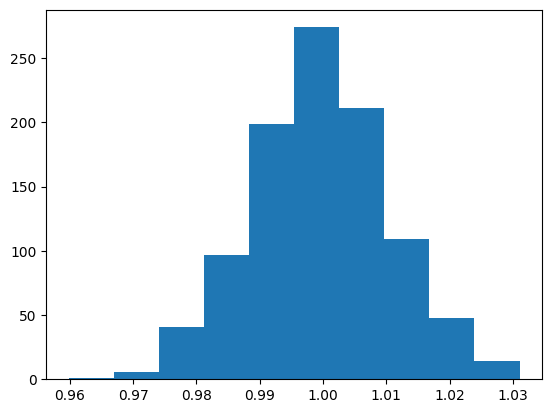

In [66]:
plt.hist(trace.posterior['beta_age'][0])

(array([  2.,  11.,  50., 144., 200., 264., 198.,  87.,  36.,   8.]),
 array([506.3083465 , 507.98544714, 509.66254777, 511.33964841,
        513.01674905, 514.69384968, 516.37095032, 518.04805095,
        519.72515159, 521.40225223, 523.07935286]),
 <BarContainer object of 10 artists>)

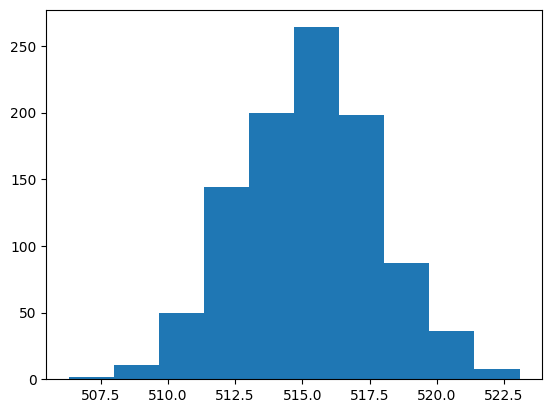

In [67]:
plt.hist(trace.posterior['beta_magic'][0])

(array([  4.,   7.,  52.,  96., 218., 246., 211.,  97.,  54.,  15.]),
 array([-21.23841364, -16.84163032, -12.44484701,  -8.04806369,
         -3.65128038,   0.74550294,   5.14228625,   9.53906957,
         13.93585288,  18.3326362 ,  22.72941951]),
 <BarContainer object of 10 artists>)

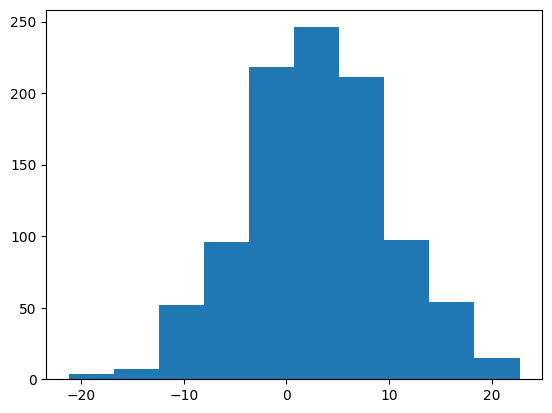

In [69]:
plt.hist(trace.posterior['intercept'][0])

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_age'}>],
       [<Axes: title={'center': 'error'}>,
        <Axes: title={'center': 'error'}>],
       [<Axes: title={'center': 'beta_magic'}>,
        <Axes: title={'center': 'beta_magic'}>]], dtype=object)

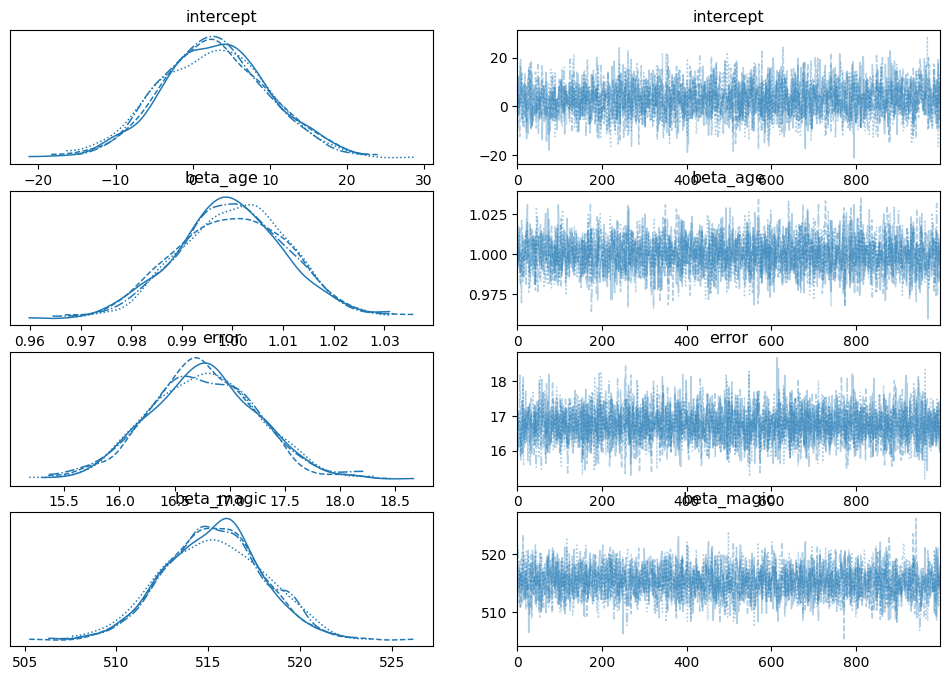

In [71]:
pm.plot_trace(trace)

### mispecified bayesian regression + prior predictive check

What happens if we use a really poor prior? Here we assign a strong prior on beta_magic and see that the results are poor. We can defend against this by running a prior predictive check. Doing so, we see that the original data are not in the range that the prior allows for.

In [142]:
with pm.Model() as model:
    alpha = pm.Normal("intercept", 0, 10)
    beta_age = pm.Normal("beta_age", mu = 0, tau = 1)
    beta_magic = pm.Normal("beta_magic", mu=0, tau=100) # wrong strong prior on beta_magic
    mu = alpha + beta_age*dragon_age + beta_magic*dragon_magic
    sigma = pm.Normal('error', 0, 1)
    obs = pm.Normal("obs",mu, sigma, observed=dragon_fire)

    trace = pm.sample(draws=1000,tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_age, beta_magic, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


(array([  2.,  15.,  62., 128., 251., 235., 173.,  98.,  25.,  11.]),
 array([2.5645732 , 2.58162817, 2.59868314, 2.61573811, 2.63279308,
        2.64984805, 2.66690301, 2.68395798, 2.70101295, 2.71806792,
        2.73512289]),
 <BarContainer object of 10 artists>)

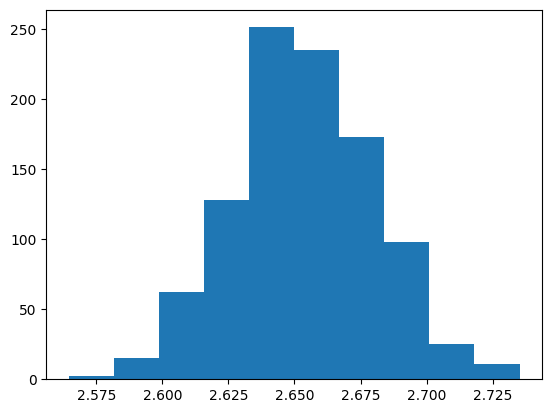

In [143]:
plt.hist(trace.posterior['beta_age'][0]) # beta age is okayyy

(array([ 10.,  23.,  83., 151., 182., 217., 183., 104.,  29.,  18.]),
 array([-0.22340538, -0.16578762, -0.10816987, -0.05055211,  0.00706564,
         0.0646834 ,  0.12230115,  0.17991891,  0.23753666,  0.29515442,
         0.35277217]),
 <BarContainer object of 10 artists>)

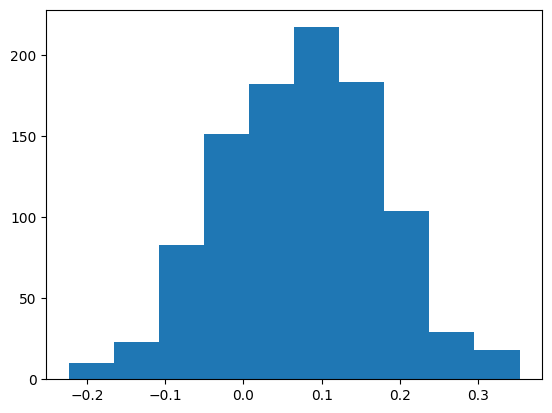

In [144]:
plt.hist(trace.posterior['beta_magic'][0]) # beta magic is wayyy off

(array([ 15.,  27., 143., 221., 279., 181., 108.,  23.,   2.,   1.]),
 array([123.16141747, 129.83518447, 136.50895147, 143.18271847,
        149.85648547, 156.53025247, 163.20401946, 169.87778646,
        176.55155346, 183.22532046, 189.89908746]),
 <BarContainer object of 10 artists>)

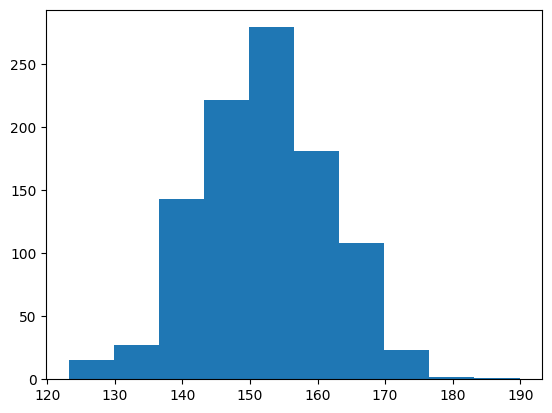

In [145]:
plt.hist(trace.posterior['intercept'][0]) # errors loaded into the intercept...

In [146]:
# note: you can't just sample all the way to simulated observations because your model requires, for instance, dragon age to be provided--it's not modeled. Can we generalize so it is? 
with model:
    idata = pm.sample_prior_predictive(random_seed=232, var_names = ['intercept', 'beta_age','beta_magic'])
    # idata = pm.sample_prior_predictive(random_seed=232) #broken!


Sampling: [beta_age, beta_magic, intercept]


In [147]:
# sample from the sampled parameters and combine with observed variables to generate pseudo-observations
# ideally we vectorize this but let's just do it the funny way for now...
num_draws = len(idata.prior.beta_age[0])
num_data = len(dragon_age)
sim_obs = np.zeros([num_draws, num_data])
for i in range(num_draws):
    sim_obs[i] = idata.prior.intercept[0][i].values + idata.prior.beta_age[0][i].values*dragon_age + idata.prior.beta_magic[0][i].values*dragon_magic

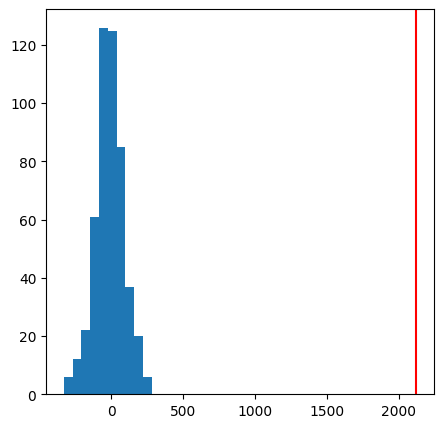

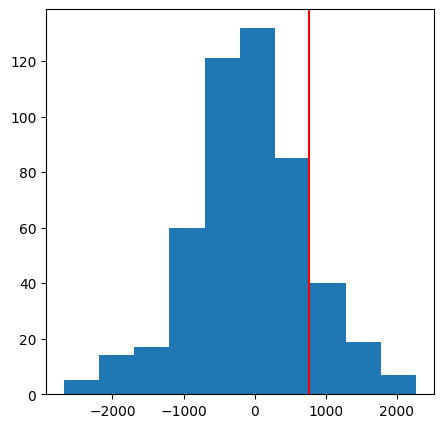

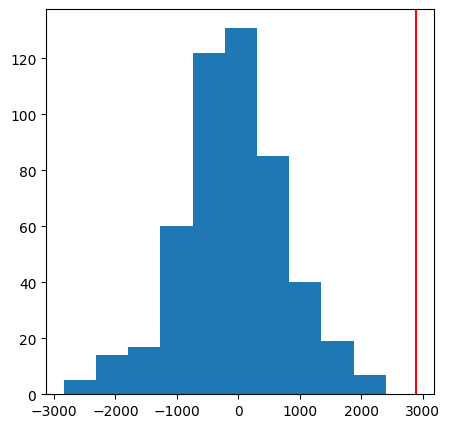

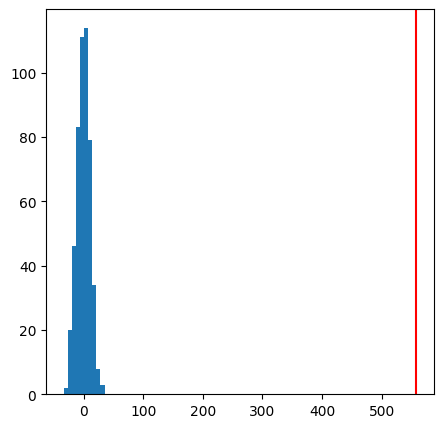

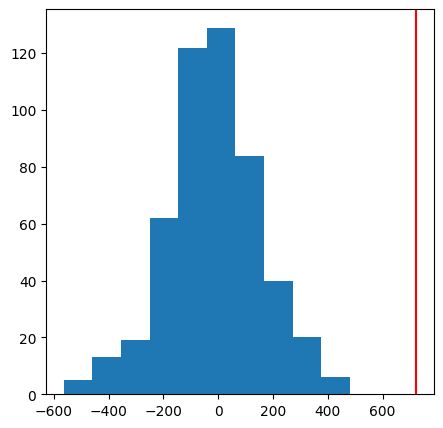

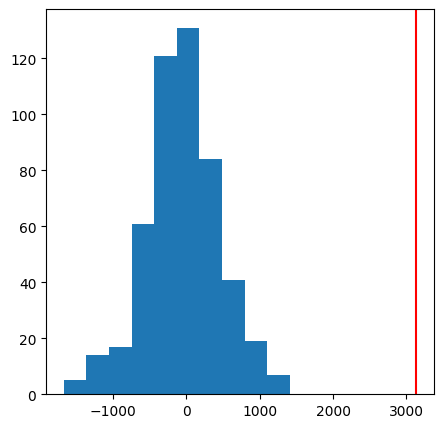

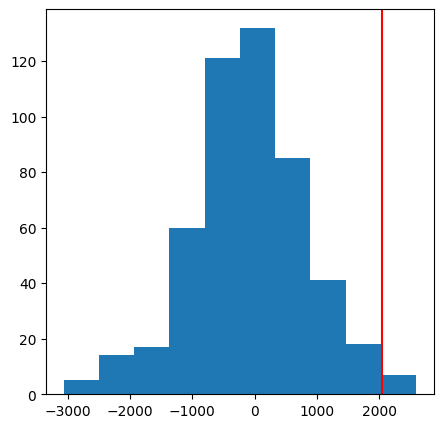

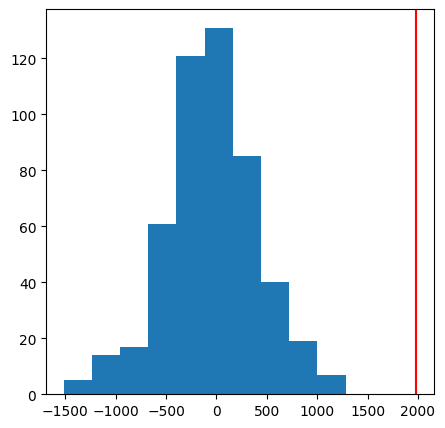

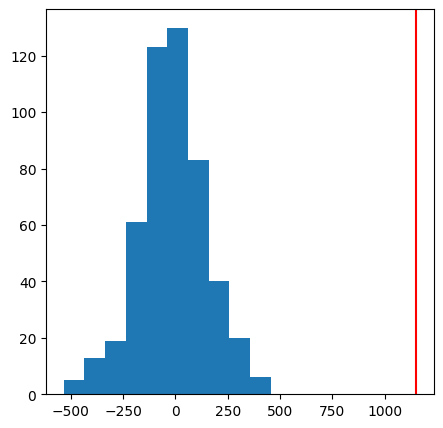

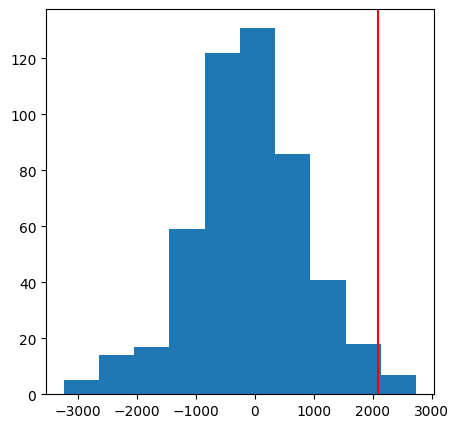

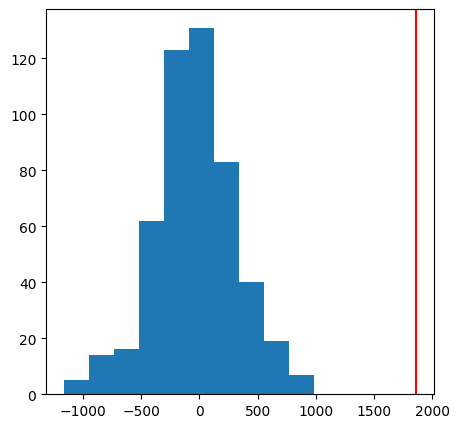

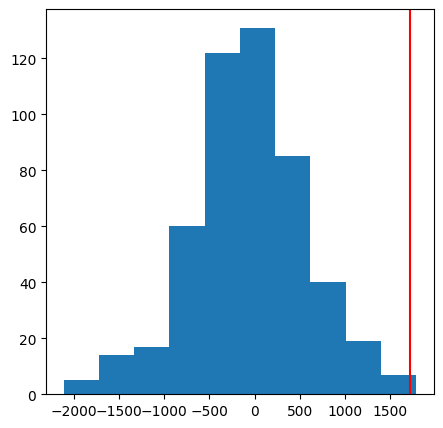

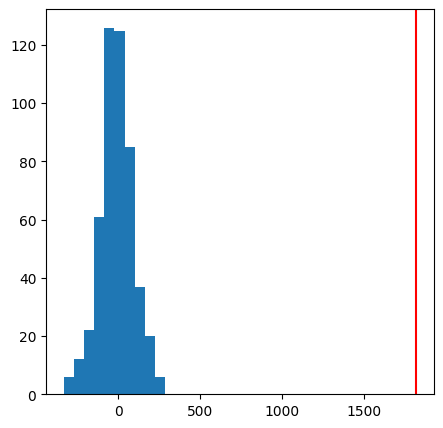

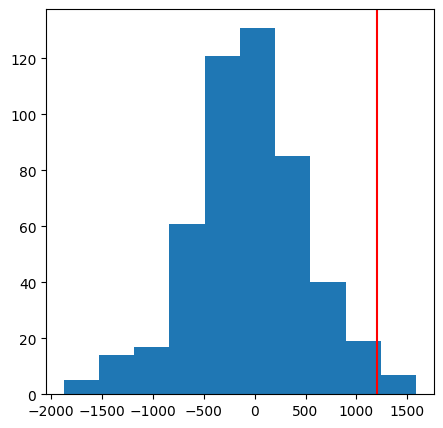

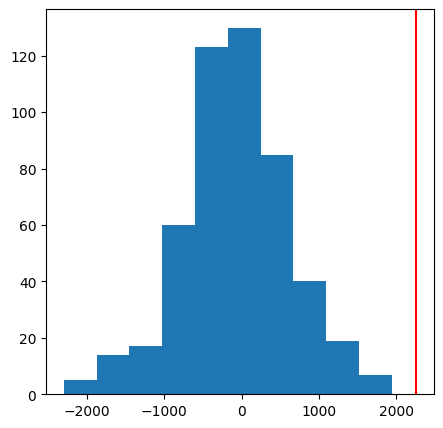

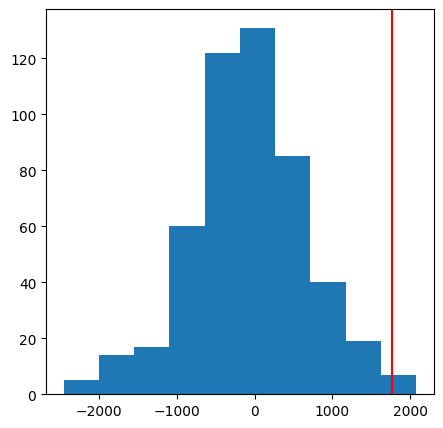

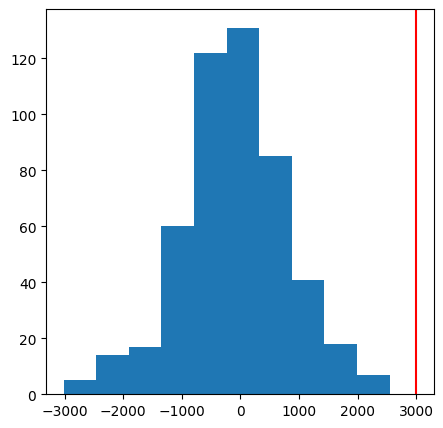

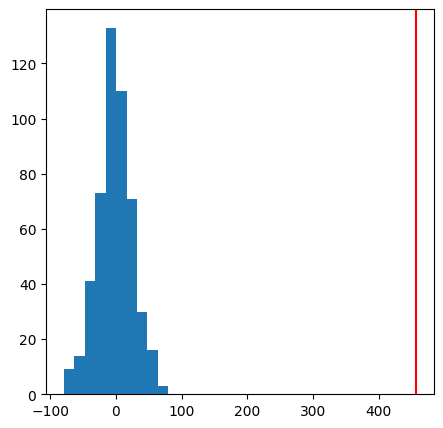

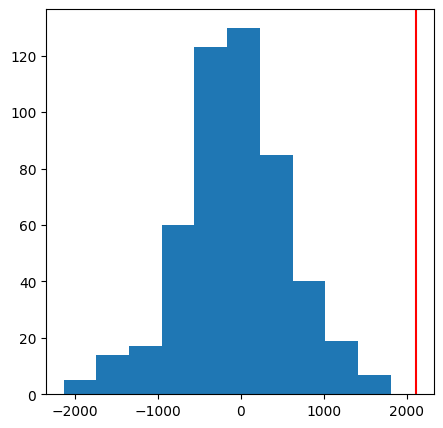

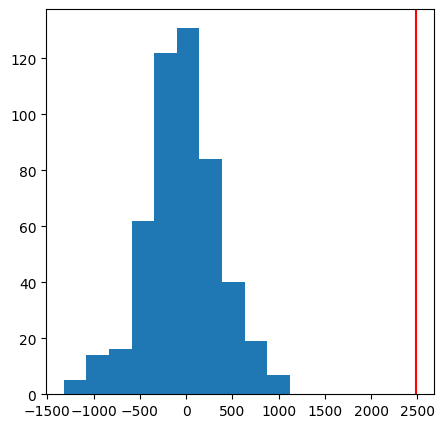

In [148]:
# plot if the data are contained within the distributions of simulated data generated for each observation
# lots of red lines are outside of our histograms--that means that, with the sampled parameters, the model's current range for guessed parameters
# does not contain the real data, meaning our model is going to have a hard time accurately honing in on what's going on!

for obs_num in range(len(dragon_fire)):
    plt.figure(figsize=(5,5,))
    sim_data = sim_obs[:, obs_num]
    plt.hist(sim_data)
    plt.axvline(dragon_fire[obs_num], color='red')

In [150]:
## just for fun check out the posterior predictive values...note that we only have obs! how can we get ppv for the predictors?

with model:
    idata.extend(pm.sample_posterior_predictive(trace, random_seed=124))

Sampling: [obs]


In [153]:
idata.posterior_predictive.obs 

<xarray.DataArray 'obs' (chain: 4, draw: 1000, obs_dim_2: 20)>
array([[[ 456.73478891, 2417.47840079, 2448.4254217 , ...,
          338.1986829 , 1824.68470722, 1262.45867765],
        [ 476.38110292, 2403.31608004, 2466.21462697, ...,
          172.15488193, 1876.90490143, 1299.5878601 ],
        [ 461.00438363, 2244.02334473, 2340.59604204, ...,
          234.97828484, 1989.26121708, 1280.56256752],
        ...,
        [ 444.52534269, 2420.61534457, 2423.52441597, ...,
          117.87244835, 2013.83036157, 1252.90266768],
        [ 407.4276452 , 2261.21595178, 2376.29266912, ...,
          192.78263917, 1827.33281253, 1386.62654641],
        [ 486.5038783 , 2397.17296897, 2481.39439137, ...,
          315.67449993, 1859.94524221, 1286.63534009]],

       [[ 469.79336943, 2330.07341705, 2443.10830045, ...,
          312.02866949, 1895.7492399 , 1213.51102477],
        [ 544.00937738, 2363.64336009, 2577.8086212 , ...,
          277.48560436, 1903.6252342 , 1227.85632535],
        [ 431.19809063, 2381.26135885, 2591.40002871, ...,
          237.84934943, 1824.37439042, 1198.54095771],
...
        [ 405.82713276, 2332.04382246, 2485.95328646, ...,
          121.55692314, 1989.29411242, 1164.4406415 ],
        [ 515.47905531, 2422.44475041, 2351.45018948, ...,
          193.58667237, 1896.92913858, 1219.57286283],
        [ 466.30319134, 2417.1502076 , 2406.98871784, ...,
          209.30031825, 1988.94173427, 1271.47565425]],

       [[ 529.25720855, 2330.39643746, 2470.37145946, ...,
          293.31946618, 1977.30337522, 1221.84601171],
        [ 358.54507526, 2208.35761974, 2545.28786534, ...,
           73.16039076, 1850.64968249, 1253.25200058],
        [ 433.42939321, 2384.82479999, 2441.36134725, ...,
          161.37897917, 1909.35365772, 1295.02181623],
        ...,
        [ 464.10688837, 2389.25207014, 2428.09897802, ...,
          313.86778219, 1942.22788822, 1196.28781561],
        [ 439.16075957, 2343.25703012, 2600.06812   , ...,
          162.27670643, 1928.88001613, 1370.78817758],
        [ 453.70084595, 2304.06996375, 2475.93483649, ...,
          289.86728585, 1856.51281837, 1339.00812555]]])
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * obs_dim_2  (obs_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19

### model dragon age and other predictors as well


let's explore a more thorough posterior predictive check by including our predictors as bayesian random variables in our model. Note the difference in what pymc lets us do after we make this change (the ppc returns not just simulated dragon_fire but also simulated values for the two predictors dragon_age and dragon_magic)


In [154]:
with pm.Model() as model:
    alpha = pm.Normal("intercept", 0, 10)
    beta_age = pm.Normal("beta_age", mu = 0, tau = 1)
    beta_magic = pm.Uniform("beta_magic", lower=0, upper=1000)
    drag_age = pm.Uniform("drag_age",lower=0, upper=5000, observed = dragon_age)
    drag_magic = pm.Uniform("drag_magic", lower=0, upper=10, observed=dragon_magic)
    mu = alpha + beta_age*drag_age + beta_magic*drag_magic
    sigma = pm.Normal('error', 0, 1)
    obs = pm.Normal("obs",mu, sigma, observed=dragon_fire)

    trace = pm.sample(draws=1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_age, beta_magic, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [156]:
with model:
    idata = pm.sample_posterior_predictive(trace, random_seed=232)

Sampling: [drag_age, drag_magic, obs]


In [158]:
idata.posterior_predictive

# look at that! since we incorporated drag_age and drag_magic into the model we now can sample from them!

<xarray.Dataset>
Dimensions:           (chain: 4, draw: 1000, drag_age_dim_2: 20,
                       drag_magic_dim_2: 20, obs_dim_2: 20)
Coordinates:
  * chain             (chain) int64 0 1 2 3
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * drag_age_dim_2    (drag_age_dim_2) int64 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
  * drag_magic_dim_2  (drag_magic_dim_2) int64 0 1 2 3 4 5 ... 14 15 16 17 18 19
  * obs_dim_2         (obs_dim_2) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
Data variables:
    drag_age          (chain, draw, drag_age_dim_2) float64 2.887e+03 ... 1.5...
    drag_magic        (chain, draw, drag_magic_dim_2) float64 5.697 ... 2.754
    obs               (chain, draw, obs_dim_2) float64 5.81e+03 ... 2.937e+03
Attributes:
    created_at:                 2024-07-22T22:25:38.173294
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.2

(array([7951., 8150., 7981., 8035., 7985., 7924., 8019., 8029., 7909.,
        8017.]),
 array([1.95909043e-01, 5.00171669e+02, 1.00014743e+03, 1.50012319e+03,
        2.00009895e+03, 2.50007471e+03, 3.00005047e+03, 3.50002623e+03,
        4.00000199e+03, 4.49997775e+03, 4.99995351e+03]),
 <BarContainer object of 10 artists>)

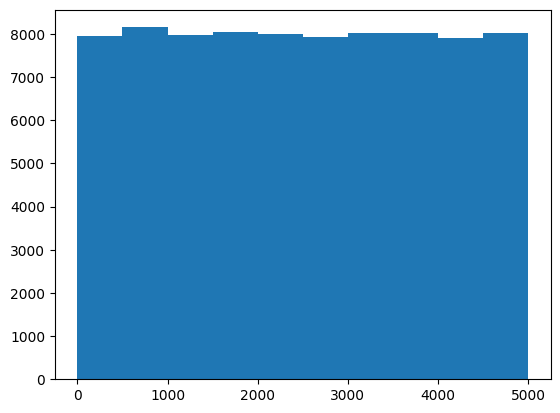

In [167]:
plt.hist(idata.posterior_predictive.drag_age.values.flatten()) # looks about the same as the distribution we gave it

(array([8021., 8143., 8051., 7989., 8051., 8089., 7874., 7941., 8021.,
        7820.]),
 array([5.97891478e-05, 1.00002146e+00, 1.99998313e+00, 2.99994480e+00,
        3.99990648e+00, 4.99986815e+00, 5.99982982e+00, 6.99979149e+00,
        7.99975316e+00, 8.99971484e+00, 9.99967651e+00]),
 <BarContainer object of 10 artists>)

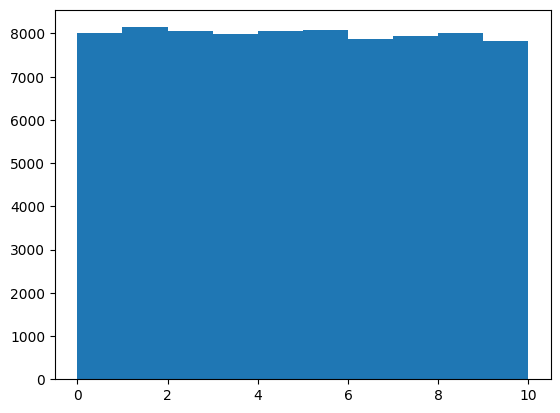

In [168]:
plt.hist(idata.posterior_predictive.drag_magic.values.flatten()) # looks like dragon magic did respond a bit to the data!
# because we don't actually have any magic scores above 4!